In [14]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [17]:
FIN_WIDTH = 400
def pad_width(Z, l=FIN_WIDTH,shift = 0):
    cwidth = Z.shape[1]
    leftpad = int((l-cwidth)/2)
    rightpad = int((l-cwidth)/2)
    fudgepad = rightpad + int(l-(leftpad+rightpad+cwidth))
    assert (shift <= leftpad) and (shift <= rightpad), "Shift must be less than or equal to the padding on either side"
    padb = np.zeros((l, leftpad+shift))
    pada = np.zeros((l, fudgepad-shift))
    return np.concatenate((padb, Z, pada), axis=1)


(400, 400)


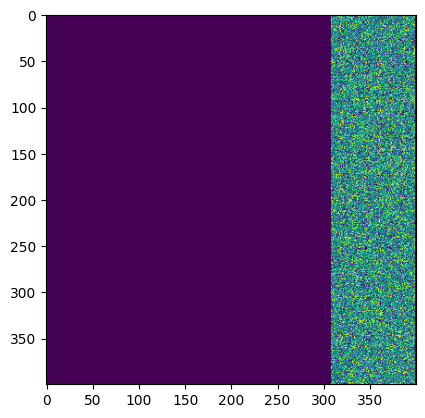

In [25]:
shift = 154
def padtester(size = 91):
    inp = np.random.rand(400, size)
    a = pad_width(inp,shift=shift)
    print(a.shape)
    plt.imshow(a)
    plt.show()


padtester()


In [29]:
def get_valid_shifts(len1,width):
    max_shift = np.floor((width-len1)/2)
    return [i for i in range(int(max_shift)+1)]

In [30]:
get_valid_shifts(91,400)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154]